In [1]:
import numpy as np
import tensorflow as tf
from skimage.io import imread
from matplotlib import pyplot as plt

%matplotlib inline

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#data_tif = imread('../Red_0007.tif')
data_tif = imread('../NDExp.tif')
#data_tif = data_tif[:,:,[0,2]]
labels_tif = imread('../NDExp_labels.tif')
labels_tif = np.moveaxis(labels_tif, 1, -1)
print(data_tif.shape, labels_tif.shape)

data_shape = data_tif.shape
label_shape = labels_tif.shape

#temp is now 4 dimensions
temp = np.zeros(label_shape[0:3] + (3,), dtype=np.float32)
temp[:, :,:,[0,1]] = labels_tif
tsum = labels_tif.max() - labels_tif.max(axis=(-1))
print("tsum", tsum.shape)
temp[:,:,:,-1] = tsum
labels_tif = temp
print(data_tif.shape, data_tif.min(axis=(0,1)).shape)
dmin = data_tif.min(axis=(1,2),keepdims=True)
dmax = data_tif.max(axis=(1,2),keepdims=True)
data = (data_tif - dmin)/(dmax - dmin)
labels = (labels_tif - labels_tif.min())/(labels_tif.max() - labels_tif.min())
print(labels[2,456, 198,:], labels.min())
#data = np.expand_dims(data, -1)
#labels = np.expand_dims(labels, -1)
data_tif.shape, data.shape, labels.shape, labels.dtype


(7, 512, 512, 3) (7, 512, 512, 2)
tsum (7, 512, 512)
(7, 512, 512, 3) (512, 3)
[0. 0. 1.] 0.0


((7, 512, 512, 3), (7, 512, 512, 3), (7, 512, 512, 3), dtype('float32'))

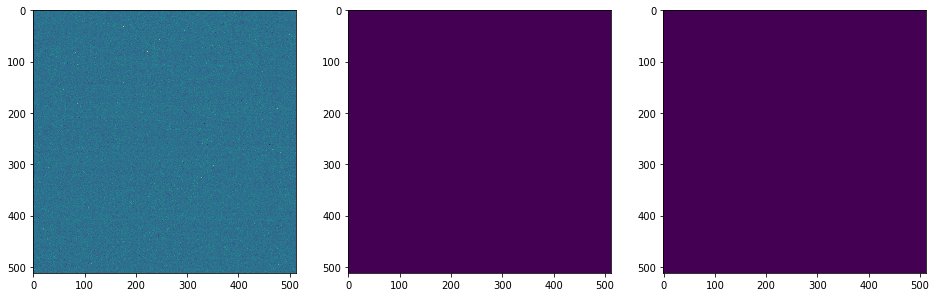

In [3]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(data[-1,:,:,1])
plt.subplot(1,3,2)
plt.imshow(labels[-1,:,:,1])
plt.subplot(1,3,3)
plt.imshow(labels[-1,:,:,2])

In [4]:
def get_patch(data, labels, rf, rx, ry, size):
    d = size//2
    ''' get all channels'''
    data_patch = data[rf, ry - d:ry  + d,rx - d:rx + d, :]
    label_patch = labels[rf, ry - d:ry  + d,rx - d:rx + d, :]
    return data_patch, label_patch

def get_batch(data, labels, num, size, ones=None, zeros=None):
    d = size//2
    batch = np.zeros((num, size, size, data.shape[-1]), dtype=np.float32)
    mask = np.zeros((num, labels.shape[-1]), dtype=np.float32)
    if ones == None:
        xrand = np.random.randint(d, data.shape[2] - d, num)
        yrand = np.random.randint(d, data.shape[1] - d, num)
        frand = np.ramdom.randint(d, data.shape[0] - d, num)
    else:
        orand = np.random.randint(2, num-2)
        fones = ones[0]
        xones = ones[2]
        yones = ones[1]
        fzeros = zeros[0]
        xzeros = zeros[2]
        yzeros = zeros[1]
        rxy = np.random.randint(0, len(ones[0]), orand)
        xrand1 = xones[rxy]
        yrand1 = yones[rxy]
        frand1 = fones[rxy]
        rxy = np.random.randint(0, len(zeros[0]), num-orand)
        xrand0 = xzeros[rxy]
        yrand0 = yzeros[rxy]
        frand0 = fzeros[rxy]
        
        xrand = np.concatenate((xrand1, xrand0))
        yrand = np.concatenate((yrand1, yrand0))
        frand = np.concatenate((frand1, frand0))
        perm = np.random.permutation(len(xrand))
        xrand = xrand[perm]
        yrand = yrand[perm]
        frand = frand[perm]
        
    for i in range(num):
        a, b = get_patch(data, labels, frand[i], xrand[i], yrand[i], size)
        #print(a.shape)
        batch[i] = a
        mask[i] = labels[frand[i], yrand[i], xrand[i], :]
    return batch, mask

In [5]:
def get_init(stdev):
    """
    Create a layer initializer
    Returns
    -------
    Normal initializer
    """
    return tf.truncated_normal_initializer(stddev=stdev)

def network(images, filters, drop=0.9):
    
    ## layer 1 - 16x6
    c = tf.layers.conv2d(images, filters[0], 5, 2, "same",
                         activation=None, kernel_initializer=get_init(0.04),
                        name="conv_01")
    
#     c = tf.nn.leaky_relu(c, alpha=0.2, name="leaky_relu_01")
    c = tf.nn.relu(c, name="relu_01")
    c = tf.nn.dropout(c,drop)
    #layer 2 - 8x8
    c = tf.layers.conv2d(c, filters[1], 3, 2, "same",
                         activation=None, kernel_initializer=get_init(0.04),
                        name="conv_02")
    
#     c = tf.nn.leaky_relu(c, alpha=0.2, name="leaky_relu_02")
    c = tf.nn.relu(c, name="relu_02")
    c = tf.nn.dropout(c, drop)
    
    #layer 3 - 4x4
    c = tf.layers.conv2d(c, filters[2], 3, 2, "same",
                         activation=None, kernel_initializer=get_init(0.04),
                        name="conv_03")
    
#     c = tf.nn.leaky_relu(c, alpha=0.2, name="leaky_relu_03")
    c = tf.nn.relu(c, name="relu_03")
    c = tf.nn.dropout(c, drop)
    
    #layer 4 - 16*32 = 4096
    c = tf.layers.flatten(c, name="flatten")
    #layer 5 - 256
    c = tf.layers.dense(c, 1024, kernel_initializer=get_init(0.04), name="dense_1024")
    c = tf.nn.relu(c)
    c = tf.nn.dropout(c, drop)
    c = tf.layers.dense(c, 256, kernel_initializer=get_init(0.04), name="dense_256")
#     c = tf.nn.leaky_relu(c, name="dense_leaky")
    c = tf.nn.relu(c, name="dense_relu_01")
    c = tf.nn.dropout(c, drop)
    
    c = tf.layers.dense(c, 64, kernel_initializer=get_init(0.04), name="dense_064")
    c = tf.nn.relu(c, name="dense_relu")
    #c = tf.nn.dropout(c,.7)
    ki = tf.truncated_normal_initializer(mean=0, stddev=4)
    
    ''' change to 2, for both channels'''
    c = tf.layers.dense(c, 3, kernel_initializer=ki, name="logits")
    #c = tf.sigmoid(c)
    return c
    
    

In [6]:

w = 32
tf.reset_default_graph()
images = tf.placeholder(tf.float32, shape=(None, w, w, 3), name="images")
masks = tf.placeholder(tf.float32, shape=(None, w, w, 3), name="masks")
mlabels = tf.placeholder(tf.float32, shape=(None, 3), name="labels")

In [7]:
filters = [64, 128, 256]
logits = network(images, filters, drop=0.6)

In [8]:
learning_rate = 0.0005
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=mlabels, logits=logits, name="sbce"))

opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9).minimize(loss)

In [9]:
#test_images = data [0:1024,:,:]
#test_labels = labels[0:1024,:,:]

train_images = data #[1024:, :, :]
train_labels = labels #[1024:, :,:]
#ones, zeros = np.where(train_labels)
#print(train_images.shape, train_labels.shape)
#print(train_labels[2,234,67,:])
sum_mask = train_labels[:, :,:,[0,1]].sum(axis=(-1), keepdims=True)
#print(sum_mask.shape)
bz = sum_mask*0
#print(bz.shape)
bz[:, w//2:-w//2, w//2:-w//2,:] = 1.

mb = sum_mask*bz

bz = bz*0 + 1
bz[:, w//2:-w//2, w//2:-w//2,:] = 0

bz = bz + sum_mask
gt0 = bz > 0
bz [gt0] = 1

iones = np.where(np.isin(mb, [1]))

izeros = np.where(np.isin(bz, [0]))
#print(bz.max())
#print(labels.shape)
for i in izeros:
    print("i", i)
    print(i.max(), i.shape, labels.reshape(-1).shape)

print()
for i in iones:
    print("i", i)
    print(i.max(), i.shape, labels.reshape(-1).shape)

i [0 0 0 ... 6 6 6]
6 (1277490,) (5505024,)
i [ 16  16  16 ... 495 495 495]
495 (1277490,) (5505024,)
i [ 29  30  31 ... 493 494 495]
495 (1277490,) (5505024,)
i [0 0 0 ... 0 0 0]
0 (1277490,) (5505024,)

i [0 0 0 ... 5 5 5]
5 (335309,) (5505024,)
i [ 16  16  16 ... 495 495 495]
495 (335309,) (5505024,)
i [ 16  17  18 ... 493 494 495]
495 (335309,) (5505024,)
i [0 0 0 ... 0 0 0]
0 (335309,) (5505024,)


In [10]:
labels.reshape(-1).shape

(5505024,)

In [11]:
b, m = get_batch(train_images, train_labels, 8, w, ones=iones, zeros=izeros)
m, m.sum(axis=0)

(array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32), array([0., 2., 6.], dtype=float32))

0 2.1193266 -0.31772587 1.5636393 [ 426.  572. 1050.]
500 0.13370213 0.8197562 6.4132214 [ 248.  318. 1482.]
1000 0.099070475 -0.103431106 9.437681 [761. 968. 319.]
1500 0.102503106 1.5586761 9.7727785 [ 255.  299. 1494.]
2000 0.100257024 0.8607909 11.478709 [524. 626. 898.]
2500 0.076677576 0.08421242 11.7404175 [ 795. 1027.  226.]
3000 0.076448806 2.5387952 14.420446 [ 212.  304. 1532.]
3500 0.08096183 0.6333137 12.297501 [647. 934. 467.]
4000 0.069755025 1.3372059 16.63584 [513. 646. 889.]
4500 0.065745614 0.6089079 14.013421 [679. 888. 481.]
5000 0.055192523 0.77163506 16.286795 [669. 862. 517.]
5500 0.06668645 3.7530906 18.398855 [ 328.  415. 1305.]
6000 0.057578035 4.624787 19.75423 [ 285.  373. 1390.]
6500 0.050859354 2.1550188 17.947767 [572. 721. 755.]
7000 0.053466465 3.1762898 18.91421 [ 430.  559. 1059.]
7500 0.052468147 0.8718915 19.70147 [680. 848. 520.]
8000 0.044410016 0.19942744 18.739485 [729. 944. 375.]
8500 0.047519382 -1.0219198 16.09719 [ 880. 1125.   43.]
9000 0.

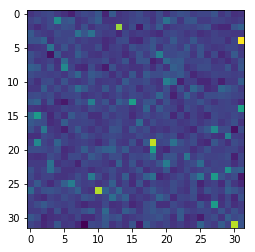

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


for i in range(10000):
    batch, blab = get_batch(train_images, train_labels, 2048, w, ones=iones, zeros=izeros)
    blog, bloss, _ = sess.run([logits, loss, opt], feed_dict={images:batch, mlabels:blab})
    if i % 500 == 0:
        print(i, bloss.sum(), blog.mean(), blog.std(), blab.sum(axis=0))
        plt.imshow(batch[4,:,:,0])
        plt.show

In [13]:
nn = 250
xs = 160
ys = 230
fs = 2
tbatch = np.zeros((nn*nn, w,w,3), dtype=np.float32)
ip = 0
for i in range(nn):
    for j in range(nn):
        rx = i + xs
        ry = j + ys
        index = j*nn + i 
        tbatch[index,:,:,:] = get_patch(data,labels, fs, rx, ry, w)[0]
        ip += 1


In [14]:
sm = tf.nn.softmax(logits)
vv, smvv = sess.run([logits, sm], feed_dict={images:tbatch})


0.0 1.0


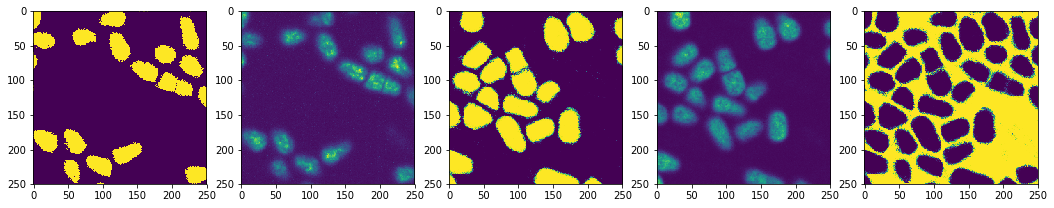

In [15]:

cv = smvv.reshape(nn,nn,3)
print(cv.min(), cv.max())
cvs = cv #1./(1 + np.exp(-cv))
plt.figure(figsize=(18,6))
plt.subplot(1,5,1)
plt.imshow(cvs[:,:,0] > .8)
plt.subplot(1,5,2)
plt.imshow(data[fs, ys:ys + nn, xs:xs + nn,0])
#plt.imshow(labels[ys:ys + nn, xs:xs + nn,0])
plt.subplot(1,5,3)
plt.imshow(cvs[:,:,1])
plt.subplot(1,5,4)
#plt.imshow(labels[ys:ys + nn, xs:xs + nn,1])
plt.imshow(data[fs, ys:ys + nn, xs:xs + nn,1])
plt.subplot(1,5,5)
plt.imshow(cvs[:,:,2])
#plt.imshow(data[ys:ys + nn, xs:xs + nn,2])

In [16]:

def batchpatch(fs, xs, ys, nnx, nny, adata):
    tbatch = np.zeros((nnx*nny, 32,32,3), dtype=np.float32)
    ip = 0
    for i in range(nnx):
        for j in range(nny):
            rx = i + xs
            ry = j + ys
            index = j*nnx + i 
            tbatch[index,:,:,:] = get_patch(adata,labels, fs, rx, ry, 32)[0]
            ip += 1
            
    vv, smvv = sess.run([logits, sm], feed_dict={images:tbatch})
    cv = vv.reshape(nny,nnx,3)
    cvs = smvv #1./(1 + np.exp(-cv))
    #print(cvs.min(), cvs.max(), cvs.mean())
    return cvs


In [17]:
resimage = np.zeros((data.shape[1], data.shape[2], 3), dtype=np.float32)

rdata = data[[1], :, :, :]
print(rdata.shape)
# rdata_tif = imread('../NDExp_Point0004_Seq0004.tif')
# dmin = rdata_tif.min(axis=(0,1),keepdims=True)
# dmax = rdata_tif.max(axis=(0,1),keepdims=True)
# rdata = (rdata_tif - dmin)/(dmax - dmin)
#plt.figure(figsize=(12, 3))
count = 1
adel = 128

i = 16
j = 16
fs = 0
adelx = 256
adely = 256
while i < (rdata.shape[2] - 16):
    adely = 256
    adelx = 256
    j = 16
    print(i, j)
    if (i + adelx + 16) > rdata.shape[2]:
            adelx = rdata.shape[2] - i - 16
            #print("i", i, j, adelx, adely, rdata.shape)
    while j < (rdata.shape[1] - 16):
        #print(j, adely)
        if (j + adely + 16) > rdata.shape[1]:
            adely = rdata.shape[1] - j - 16
            #print("j", i, j, adelx, adely)
        p = batchpatch(fs, i, j, adelx, adely, rdata)
        resimage[j:j+adely, i:i+adelx, :] = p.reshape(adely,adelx,3)
        
        j += adely
    i += adelx
    
# di = data.shape[1] - i
# dj = data.shape[0] - j



(1, 512, 512, 3)
16 16
272 16


In [18]:
from skimage.io import imsave
imsave("/ssd1/cjw/out.tif", np.moveaxis(resimage, -1, 0), plugin='tifffile')
resimage.shape

(512, 512, 3)

(512, 512, 3)


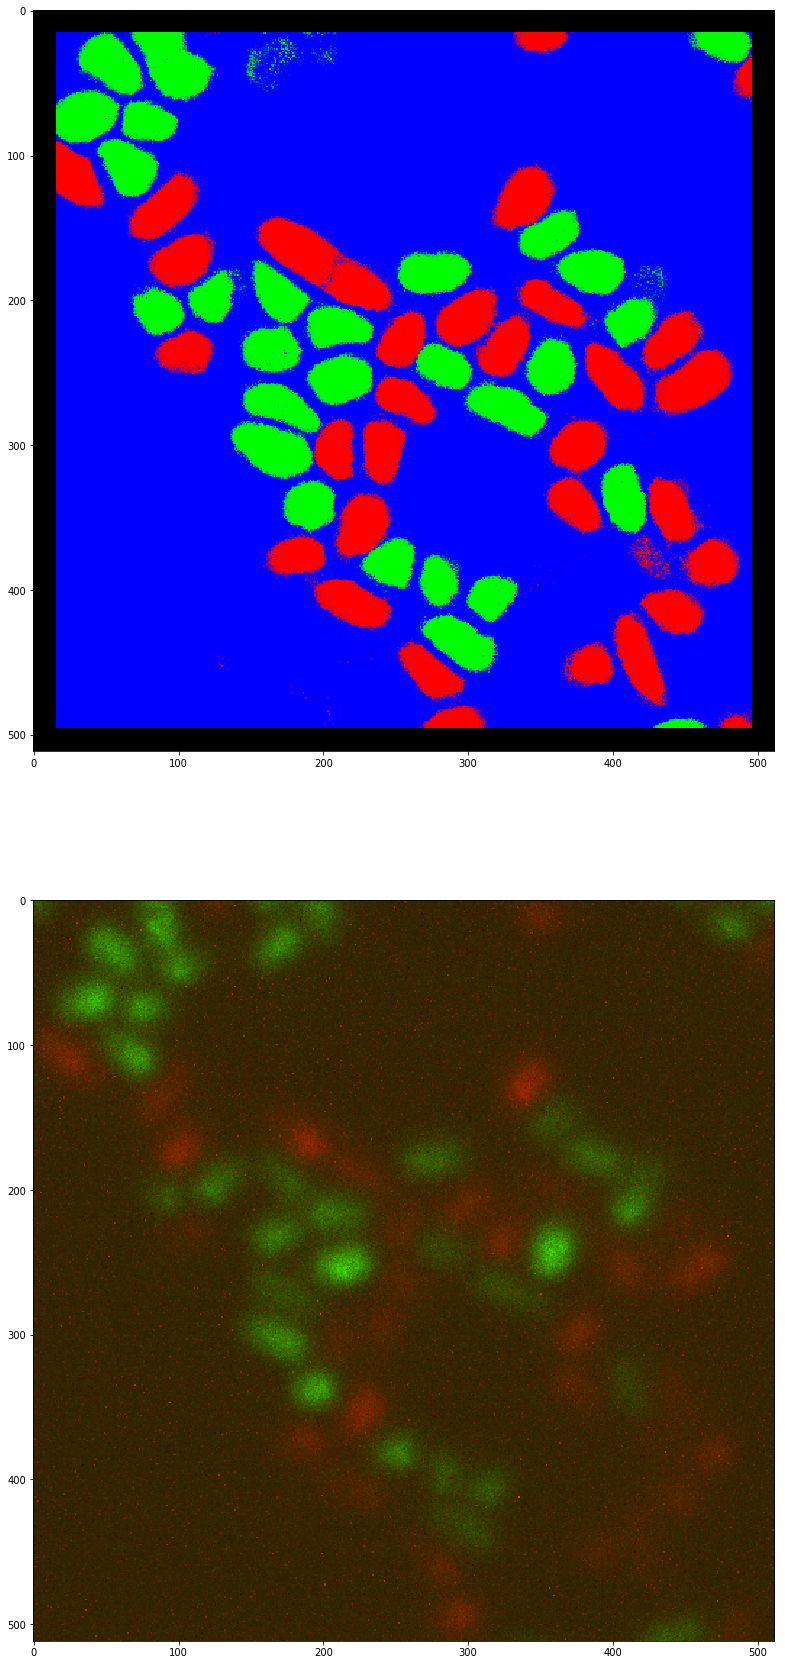

In [19]:
e1, e2, e3 = resimage.shape
showimage = np.zeros((e1, e2, 3), dtype=np.float32)
showimage[:,:,[0,1]] = resimage[:,:,[0,1]]
plt.figure(figsize=(15,30))
plt.subplot(2,1,1)
plt.imshow(resimage) #showimage)
plt.subplot(2,1,2)
datax = rdata.copy()
datax = datax[0]
datax[:,:,2] = 0
print(datax.shape)
plt.imshow(datax)
plt.savefig('/ssd1/cjw/out.pdf')


In [20]:
resimage.min()

0.0

In [35]:
#data_tif = imread('../Red_0007.tif')
data4_tif = imread('../NDExp_Point0022_Seq0022.tif')
data4_tif = np.expand_dims(data4_tif, 0)
print(data4_tif.shape)
#data4_tif = data4_tif[:,:, :]
#labels4_tif = imread('../red_green_0007.tif')

print(data4_tif.shape, data4_tif.min(axis=(1,2)).shape)
dmin = data4_tif.min(axis=(1,2),keepdims=True)
print(dmin,dmax)
dmax = data4_tif.max(axis=(1,2),keepdims=True)
data4 = (data4_tif - dmin)/(dmax - dmin)
#labels4 = (labels4_tif - labels4_tif.min())/(labels4_tif.max() - labels4_tif.min())
#labels4 = np.moveaxis(labels4, 0, -1)
#data = np.expand_dims(data, -1)
#labels4 = np.expand_dims(labels, -1)

#data4 = np.expand_dims(data4, 0)

#data4 = data4[:, -513:, 0:512, :]
data4.shape#, labels4.shape

(1, 2044, 2048, 3)
(1, 2044, 2048, 3) (1, 3)
[[[[  44   41 1928]]]] [[[[  875  2111 11589]]]]


(1, 2044, 2048, 3)

In [36]:
resimage2 = np.zeros((data4.shape[1], data4.shape[2], 3), dtype=np.float32)

#plt.figure(figsize=(12, 3))
count = 1
adel = 128

i = 16
j = 16

adelx = 256
adely = 256
while i < (data4.shape[2] - 16):
    adely = 256
    adelx = 256
    j = 16
    if (i + adelx + 16) > data4.shape[2]:
            adelx = data4.shape[2] - i - 16
            #print("i", i, j, adelx, adely)
    while j < (data4.shape[1] - 16): 
        if (j + adely + 16) > data4.shape[1]:
            adely = data4.shape[1] - j - 16
            #print("j", i, j, adelx, adely)
        p = batchpatch(0, i, j, adelx, adely, data4)
        #print(p.shape)
        resimage2[j:j+adely, i:i+adelx] = p.reshape(adely,adelx,3)
        
        j += adely
    i += adelx
    
di = data4.shape[1] - i
dj = data4.shape[0] - j

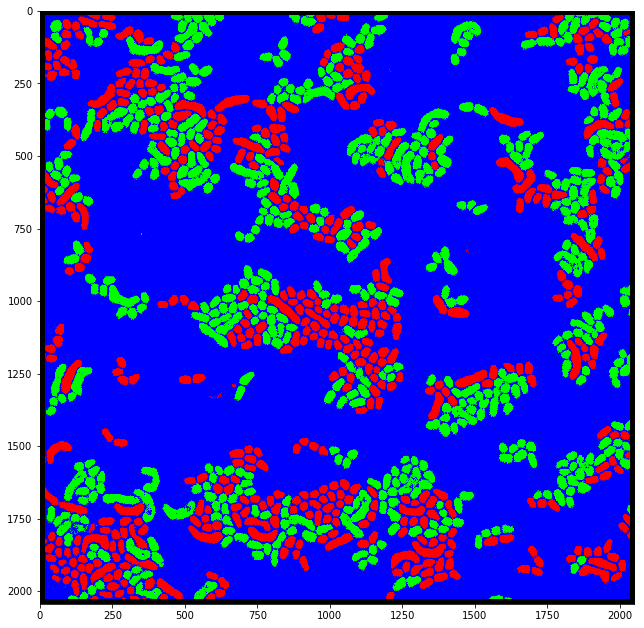

In [37]:
plt.figure(figsize=(24,24))
plt.subplot(2,1,1)
plt.imshow(resimage2[:,:,:])
# plt.subplot(2,1,2)
# c = np.zeros((labels4.shape[0], labels4.shape[1], 3), dtype=np.float32)
# c[:,:,[0,1]] = labels4
# plt.imshow(data4[0])

In [38]:
imsave("/ssd1/cjw/sez/out22.tif", np.moveaxis(resimage2, -1, 0), plugin='tifffile')

In [3]:
!pwd

/ssd1/cjw/sez/Net


In [41]:
saver = tf.train.Saver()
saver.save(sess, '/ssd1/cjw/sez', global_step=10000)

'/ssd1/cjw/sez-10000'